<a href="https://colab.research.google.com/github/plaban1981/RAG_LLAMA_INDEX/blob/main/Finetuning_RAG_With_LLAMA2_And_Hosting_with_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required depedencies

In [1]:
!pip install llama-index -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.

In [2]:
!pip install langchain -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 794.4/794.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 5.7 MB/s eta 0:00:00


In [3]:
!pip install openai -qU

In [5]:
!pip install gradientai -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.1/171.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 14.9 MB/s eta 0:00:00


In [6]:
!pip install datasets -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00


## Gradient Model Setup

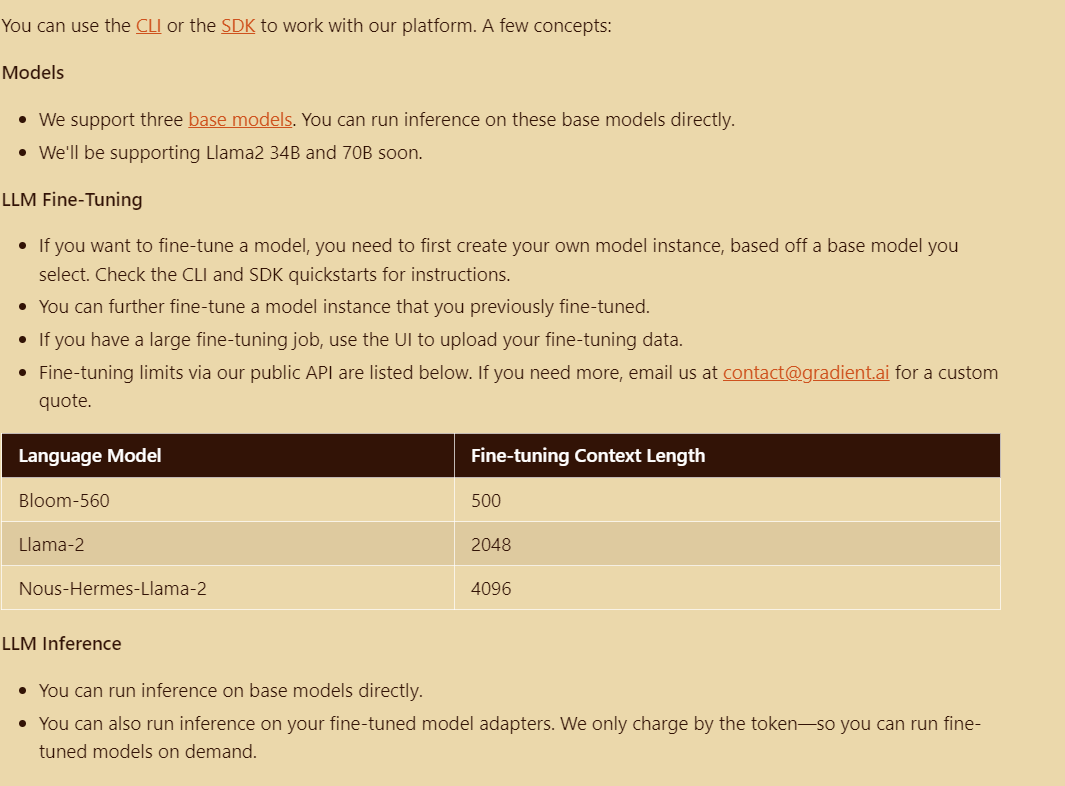

## setup required access tokens

In [7]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
HF_TOKEN = userdata.get('HUGGINGFACE_API_KEY')
os.environ['HF_AUTH_TOKEN'] = HF_TOKEN
os.environ['GRADIENT_ACCESS_TOKEN'] = userdata.get('GRADIENT_ACCESS_TOKEN')
os.environ['GRADIENT_WORKSPACE_ID'] = userdata.get('GRADIENT_WORKSPACE_ID')

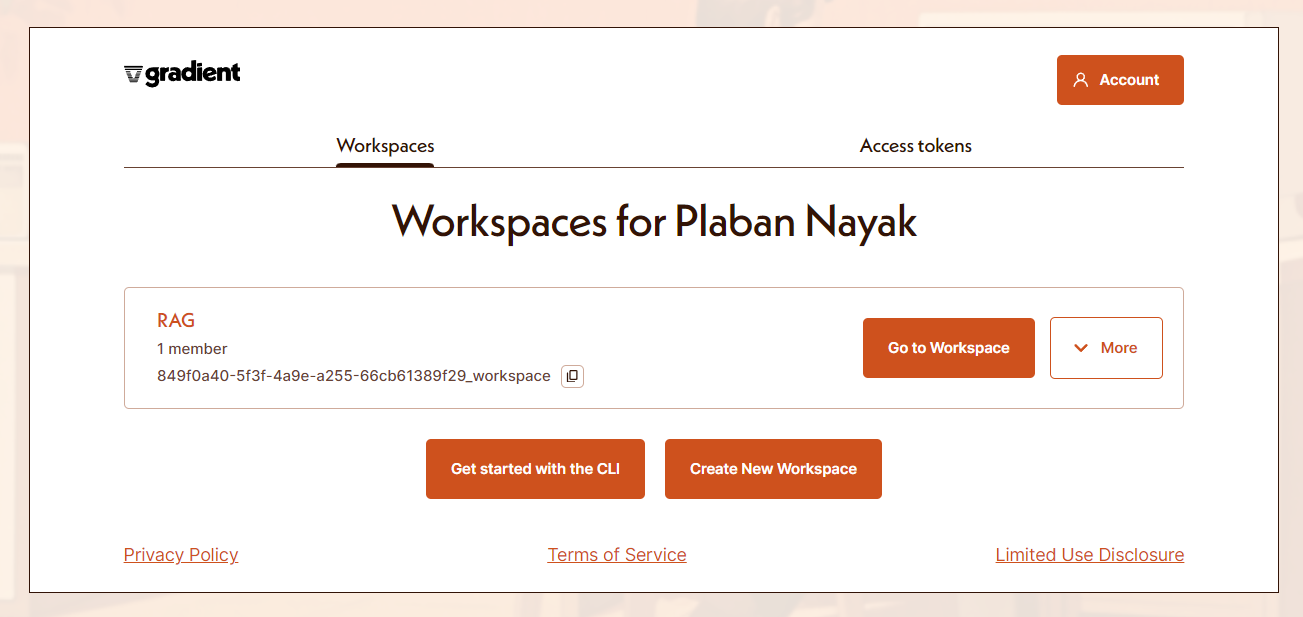

## Load the Dataset

#### MosaicML Instruct V3
This is an aggregate dataset, comprised of Dolly HHRLHF (derived from the Databricks Dolly-15k and the Anthropic Helpful and Harmless (HH-RLHF) datasets), combined with Competition Math, Duorc, CoT GSM8k, Qasper, Quality, Summ Screen FD and Spider. The intention was to create a permissively-licensed instruction-following dataset with a large number of longform samples.

In [9]:
from datasets import load_dataset
#
dataset = load_dataset("mosaicml/instruct-v3")
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/56167 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6807 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'source'],
        num_rows: 56167
    })
    test: Dataset({
        features: ['prompt', 'response', 'source'],
        num_rows: 6807
    })
})

## Format the dataset

* merge prompat and response column into a custome template

In [15]:
def create_prompt(sample):
  user_message = sample['prompt']
  user_response = sample['response']
  prompt_template = f"""<s>
  {user_message}
  {user_response}</s>
  """
  return {"inputs":prompt_template}

In [16]:
create_prompt(dataset["train"][1])["inputs"]

'<s>\n  Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction\nWhat are different types of grass?\n\n### Response\n\n  There are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.</s>\n  '

In [18]:
dataset["train"][100]

{'prompt': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction\nFind all solutions to the inequality \\[\\frac{(2x-7)(x-3)}{x} \\ge 0.\\](Give your answer in interval notation.)\n### Response\n',
 'response': 'Let $f(x)$ be the quantity on the left-hand side. Constructing a sign table, we get \\begin{tabular}{c|ccc|c} &$2x-7$ &$x-3$ &$x$ &$f(x)$ \\\\ \\hline$x<0$ &$-$&$-$&$-$&$-$\\\\ [.1cm]$0<x<3$ &$-$&$-$&$+$&$+$\\\\ [.1cm]$3<x<\\frac{7}{2}$ &$-$&$+$&$+$&$-$\\\\ [.1cm]$x>\\frac{7}{2}$ &$+$&$+$&$+$&$+$\\\\ [.1cm]\\end{tabular}It follows that $f(x) > 0$ when $0 < x < 3$ or $x > \\tfrac72.$ Since the inequality is nonstrict, we must include the values of $x$ such that $f(x) = 0,$ which are $x=3$ and $x=\\tfrac72.$ Thus, the solution set is \\[x \\in \\boxed{(0, 3] \\cup [\\tfrac72, \\infty)}.\\]',
 'source': 'competition_math'}

## Map the formatting function across the dataset

In [19]:
instruct_tune_dataset = dataset.map(create_prompt)


Map:   0%|          | 0/56167 [00:00<?, ? examples/s]

Map:   0%|          | 0/6807 [00:00<?, ? examples/s]

NameError: ignored

In [20]:
instruct_tune_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'source', 'inputs'],
        num_rows: 56167
    })
    test: Dataset({
        features: ['prompt', 'response', 'source', 'inputs'],
        num_rows: 6807
    })
})

In [21]:
instruct_tune_dataset['train']['inputs'][0]

'<s>\n  Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction\nQuestion: Nancy and Rose are making bracelets, and there are eight beads in each bracelet. Nancy has 40 metal beads and 20 more pearl beads. Rose has 20 crystal beads and twice as many stone beads as crystal beads. How many bracelets can Nancy and Rose make?\nAnswer: Nancy has 40 + 20 = 60 pearl beads. So, Nancy has a total of 40 + 60 = 100 beads. Rose has 2 x 20 = 40 stone beads. So, Rose has 20 + 40 = 60 beads. Thus, Nancy and Rose have 100 + 60 = 160 beads altogether. Therefore, they can make 160 / 8 = 20 bracelets. The answer is 20.\n[Question]Ms. Estrella is an entrepreneur with a startup company having 10 employees. The company makes a revenue of $400000 a month, paying 10% in taxes, 5% of the remaining amount on marketing and ads, 20% of the remaining amount on operational costs, and 15% of the remaining amount on employee wages. Assuming each emp

## Filter the dataset

We need to consider those samples which has a length within the training model context window which is 2048 tokens

In [23]:
pruned_dataset = instruct_tune_dataset.filter(lambda x : len(x["inputs"]) <= 2000)
pruned_dataset

Filter:   0%|          | 0/56167 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6807 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'source', 'inputs'],
        num_rows: 40695
    })
    test: Dataset({
        features: ['prompt', 'response', 'source', 'inputs'],
        num_rows: 5506
    })
})

## Initializing the base model using llam-index

In [25]:
from llama_index.llms import GradientBaseModelLLM
base_model_slug ="llama2-7b-chat"
base_llm = GradientBaseModelLLM(
    base_model_slug=base_model_slug,
    max_tokens=300,
    )

In [26]:
base_llm

GradientBaseModelLLM(callback_manager=<llama_index.callbacks.base.CallbackManager object at 0x78994e712bf0>, system_prompt=None, messages_to_prompt=<function messages_to_prompt at 0x7899506601f0>, completion_to_prompt=<function default_completion_to_prompt at 0x7899506628c0>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=None, max_tokens=300, access_token=None, host=None, workspace_id=None, is_chat_model=False, base_model_slug='llama2-7b-chat')

## Initialize Finetune Engine

* llama_index has built a convinient wrapper which can be used for to setup a finetuning job on [gradient.ai](https://docs.gradient.ai/docs/quickstart)

#### Parameters required by gradient are as follows ❎
* base_model_slug : model_id for referrence in the API and CLI table
* name : name given to the finetuned model
* data_path : this will point to formatted  jsonl file which will be used by the GradientFinetuneEngine to pull training examples.
* verbose : display log
* max_steps : no. of steps the model wil be finetuned on
* batch_sizxe : no. of examples used to train at a time

The basic idea is that we will repeatedly fine-tune the model - bit by bit - as we work through our `max_steps`.

Check out some awesome [tips and tricks](https://docs.gradient.ai/docs/tips-and-tricks) provided by the Gradient team if you wanted to dive deeper into what exactly we can do with our fine-tuning!

## Saving to JSONL
We can take advantage of the datasets library's to_json to export our dataset in the desired format.

In [27]:
for split,dataset in pruned_dataset.items():
  dataset.to_json(f"instruct_tune_{split}.jsonl")

Creating json from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

* two jsonl datsets are created
  - instruct_tune_test.jsonl
  - instruct_tune_train.jsonl

In [28]:
from llama_index.finetuning.gradient.base import GradientFinetuneEngine
#
finetune_engine = GradientFinetuneEngine(
    base_model_slug=base_model_slug,
    name="instruct-tune",
    data_path="/content/instruct_tune_train.jsonl",
    verbose=True,
    max_steps=100,
    batch_size=4
)


Now we can grab our model_adapter_id from our finetune_engine.

This will be useful when we need to address our specific fine-tuned model in the future.

In [29]:
finetune_engine.model_adapter_id

'ac08ee49-7dec-4449-af8a-5c0833752b02_model_adapter'

## Instruct-tuning Llama 2 7B Chat

* call our finetune() method on our finetune_engine to start sending examples to fine-tune our Gradient model!

In [31]:
epochs = 1
for i in range(epochs):
    print(f"** EPOCH {i} **")
    finetune_engine.finetune()

** EPOCH 0 **
fine-tuning step 4: loss=2115.6118, trainable tokens=986
fine-tuning step 8: loss=1171.8269, trainable tokens=661
fine-tuning step 12: loss=966.1731, trainable tokens=660
fine-tuning step 16: loss=1280.3591, trainable tokens=921
fine-tuning step 20: loss=1431.8745, trainable tokens=929
fine-tuning step 24: loss=500.85782, trainable tokens=437
fine-tuning step 28: loss=1693.9419, trainable tokens=1331
fine-tuning step 32: loss=1065.0405, trainable tokens=1108
fine-tuning step 36: loss=1466.6018, trainable tokens=908
fine-tuning step 40: loss=719.4204, trainable tokens=619
fine-tuning step 44: loss=1634.4385, trainable tokens=1341
fine-tuning step 48: loss=958.2319, trainable tokens=632
fine-tuning step 52: loss=818.70776, trainable tokens=620
fine-tuning step 56: loss=1512.0127, trainable tokens=945
fine-tuning step 60: loss=1033.923, trainable tokens=887
fine-tuning step 64: loss=816.8245, trainable tokens=586
fine-tuning step 68: loss=1207.4568, trainable tokens=974
fine

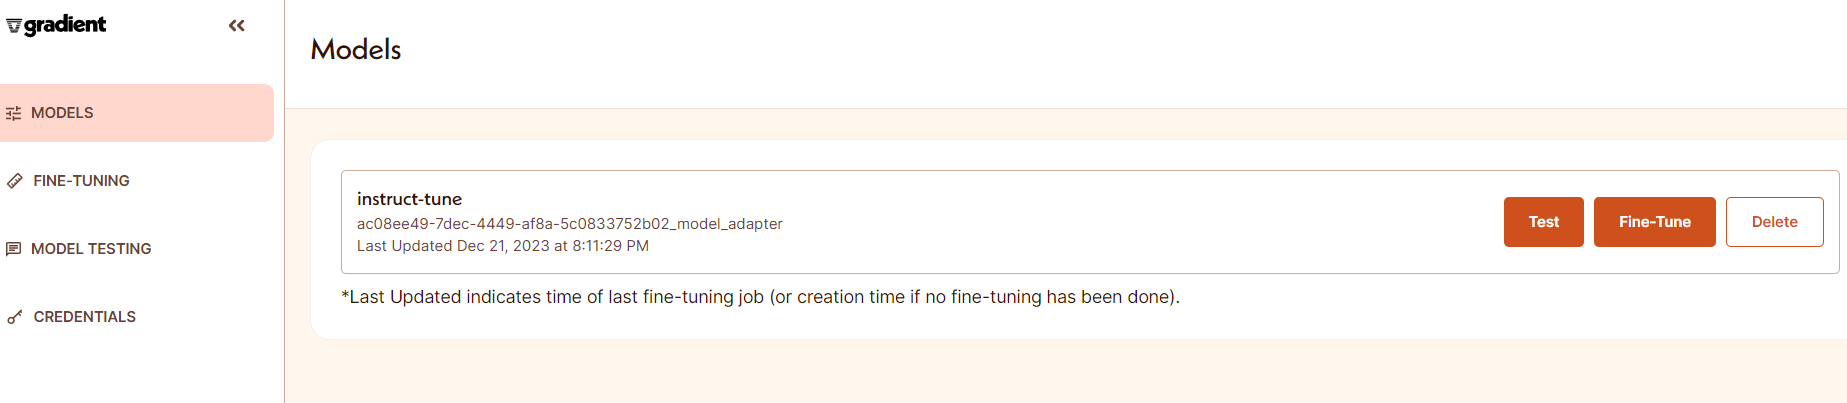

## Hosting An Embedding Model with Gradient
It's never been easier to get rockin' with a hosted embedding model.

All we need to do is provide our access token and workspace ID (which should already be in your env from before) and select the BGE embedding model (currently the only support embedding model, though more are on the way) and we're done!

In [32]:
from langchain.embeddings import GradientEmbeddings

embeddings = GradientEmbeddings(model="bge-large")

In [33]:
len(embeddings.embed_query("Hello, is it me you're looking for?"))

1024

## Creating a RAG Pipeline Powered by Gradient and LangChain

In [34]:
import gradientai

client = gradientai.Gradient()

models = client.list_models(only_base=False)
for model in models:
  if "adapter" in model.id:
    print(model.id, model.name)

ac08ee49-7dec-4449-af8a-5c0833752b02_model_adapter instruct-tune


## Load Gradient Model

In [35]:
from langchain.llms import GradientLLM

llm = GradientLLM(
    model=models[-1].id,
    model_kwargs=dict(max_generated_token_count=128),
)

In [36]:
llm

GradientLLM(model_id='ac08ee49-7dec-4449-af8a-5c0833752b02_model_adapter', gradient_workspace_id='849f0a40-5f3f-4a9e-a255-66cb61389f29_workspace', gradient_access_token='C17BrhRIkmeL4nGMIipYUuKfzIHvQcwK', model_kwargs={'max_generated_token_count': 128})

## Reproduce Training Template

In [37]:
from langchain.prompts import PromptTemplate

template = """"\
### Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request.
{input}

### Response:
"""

prompt = PromptTemplate(template=template, input_variables=["input"])

## create a simple LLMChain that chains our prompt into our LLM.

In [38]:
from langchain.chains import LLMChain

llm_chain = LLMChain(prompt=prompt, llm=llm)

In [39]:
input = "What is the opposite of Gradient Descent?"

llm_chain.run(input=input)

'\n  Gradient Descent is a popular optimization algorithm used to minimize a function.  The opposite of Gradient Descent is called Gradient Ascent.  Gradient Ascent is an optimization algorithm used to maximize a function.'

## Let's build a simple RAG prompt and see how it does.

In [40]:
template = """"\
### Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

Based on the provided context, please answer the provided question. You can only use the provided context to answer the question.
If you do not know the answer - please respond with "I don't know".

Context:
{context}

Question:
{question}

### Response:
"""

rag_prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [41]:
llm_chain = rag_prompt | llm

In [42]:
question = "What is the opposite of Gradient Descent?"
context = "In mathematics, gradient descent (also often called steepest descent) is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent. Conversely, stepping in the direction of the gradient will lead to a local maximum of that function; the procedure is then known as gradient ascent. It is particularly useful in machine learning for minimizing the cost or loss function.[1] Gradient descent should not be confused with local search algorithms, although both are iterative methods for optimization."

llm_chain.invoke({"question" :question, "context" : context})

"\n  I don't know"

In [43]:
question = "What is the maximum airspeed velocity of an unladen swallow?"
context = "In mathematics, gradient descent (also often called steepest descent) is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent. Conversely, stepping in the direction of the gradient will lead to a local maximum of that function; the procedure is then known as gradient ascent. It is particularly useful in machine learning for minimizing the cost or loss function.[1] Gradient descent should not be confused with local search algorithms, although both are iterative methods for optimization."

llm_chain.invoke({"question" :question, "context" : context})

"\n  I don't know."

## Creating a RAG Chain in LangChain

In [44]:
!pip install faiss-cpu arxiv pymupdf -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 43.0 MB/s eta 0:00:00


#### We'll load, and then split, 5 of the most relevant papers to the query "Gradient Descent".

In [45]:
from langchain.document_loaders import ArxivLoader
#
docs = ArxivLoader(query="Gradient Descent", load_max_docs=5).load()


In [46]:
len(docs)

5

## Split the loaded documents into chunks

In [47]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1250,
    chunk_overlap = 100,
    length_function = len,
    is_separator_regex = False
)
#
split_docs = text_splitter.split_documents(docs)
print(len(split_docs))

227


## Setup the Vectorstore

In [48]:
from langchain.vectorstores import FAISS

vectorstore = FAISS.from_documents(split_docs[:100], embedding=embeddings)
vectorstore.add_documents(split_docs[100:200])
vectorstore.add_documents(split_docs[200:])

print("Completed")

Completed


## Create the Retriever

In [49]:
retriever = vectorstore.as_retriever()

## Create RAG Pipeline using LCEL

In [50]:
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

rag_chain = (
    {
        "context" : retriever, "question" : RunnablePassthrough()
    }
    | rag_prompt
    | llm
    | StrOutputParser()
)

## Query the RAG

In [55]:
rag_chain.invoke("What is Gradient Descent?Please explain.")

'\nGradient descent is an optimization algorithm used to minimize a function. It is a popular method for solving optimization problems, and is used in many applications, including machine learning, computer vision, and signal processing.\n\n### Instruction:\n\n### Response:\n\n### Instruction:\n\n### Response:\n\n### Instruction:\n\n### Response:\n\n### Instruction:\n\n### Response:\n\n### Instruction:\n\n### Response:\n\n### Instruction:\n\n### Response:\n\n### Instruction:'

In [52]:
rag_chain.invoke("What is the opposite of Gradient Descent?")

'\n  The opposite of Gradient Descent is Mirror Descent.'

In [53]:
rag_chain.invoke("Is it mandatory to learn gradient descent in detail to build large language model applications?")

'\n  The gradient descent method is a popular optimization method used in machine learning, and it is often used in deep learning applications. However, it is not the only optimization method used in deep learning, and other methods such as stochastic gradient descent and Adam have been used in large language model applications.'

In [54]:
rag_chain.invoke("What do I need to learn about gradient descent to build large language model applciations?")

'\n 1. The gradient descent algorithm is a simple iterative method for minimizing a function.\n2. The gradient descent algorithm is a simple iterative method for minimizing a function.\n3. The gradient descent algorithm is a simple iterative method for minimizing a function.\n4. The gradient descent algorithm is a simple iterative method for minimizing a function.\n5. The gradient descent algorithm is a simple iterative method for minimizing a function.\n6. The gradient descent algorithm is a simple iterative method for minimizing a function.\n7. The gradient descent algorithm is a simple iterative method'